In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Scikit-learn nos ofrece una variedad ampliada de modelos Naive Bayes, para este problema usamos MultinomialNB que es pensado para este tipo de problemas
from sklearn.naive_bayes import MultinomialNB   

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# TP3: Detector de SPAM

Uno de los problemas más comunes en la clasificación es la detección de correos electrónicos SPAM. Uno de los primeros modelos utilizados para abordar este problema fue el clasificador de Bayes ingenuo. La detección de SPAM es un problema persistente en el mundo digital, ya que los spammers continúan adaptando sus estrategias para eludir los filtros de correo no deseado. Además del clasificador de Bayes ingenuo, se han desarrollado y utilizado una variedad de técnicas más avanzadas en la detección de SPAM, que incluyen algoritmos de aprendizaje automático, redes neuronales y métodos basados en reglas.

En este trabajo práctico, utilizaremos un conjunto de datos que consta de 4601 observaciones de correos electrónicos, de los cuales 2788 son correos legítimos y 1813 son correos SPAM. Dado que el contenido de los correos electrónicos es un tipo de dato no estructurado, es necesario procesarlo de alguna manera. Para este conjunto de datos, ya se ha aplicado un procesamiento típico en el Procesamiento del Lenguaje Natural (NLP), que consiste en contar la frecuencia de palabras observadas en los correos.

El procesamiento de lenguaje natural (NLP) desempeña un papel fundamental en la detección de SPAM, ya que permite analizar el contenido de los correos electrónicos y extraer características relevantes para la clasificación. Además de contar la frecuencia de palabras, se pueden utilizar técnicas más sofisticadas, como la extracción de características semánticas y el análisis de sentimientos, para mejorar la precisión de los modelos de detección de SPAM.

En este proceso, se cuenta la cantidad de ocurrencias de cada palabra en los diferentes correos.

![spam counter](./spam.png)

Con el fin de preservar la privacidad de los mensajes, la frecuencia de palabras se encuentra normalizada. El conjunto de datos está compuesto por 54 columnas de atributos que se denominan:

- `word_freq_XXXX`: Donde `XXXX` es la palabra o símbolo. Los valores son enteros que van de 0 a 20k.

Además, hay una columna adicional llamada `spam`, que es 1 si el correo es SPAM o 0 si no lo es.

Los clasificadores de Bayes ingenuos fueron los primeros filtros utilizados por las aplicaciones de correo electrónico, basados en este principio de palabras. La idea es que, partiendo de un dato a priori sobre la probabilidad de que un correo sea SPAM o no, ciertas palabras nos indicarán que la probabilidad a posteriori, dadas esas palabras, es más probable que el correo sea SPAM o no.

In [110]:
dataset = pd.read_csv("dataset/spambase.csv") # cargando los datos desde un CSV
dataset.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,spam
0,0,640,640,0,320,0,0,0,0,0,...,0,0,0,0,0,0,778,0,0,1
1,210,280,500,0,140,280,210,70,0,940,...,0,0,0,0,132,0,372,180,48,1
2,60,0,710,0,1230,190,190,120,640,250,...,60,0,0,10,143,0,276,184,10,1
3,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,137,0,137,0,0,1
4,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,135,0,135,0,0,1


Para obtener las palábras más usadas podemos hacer un `groupby`:

In [111]:
column_sum = dataset.groupby(by="spam", as_index=False).sum()

In [112]:
# Separar las palabras más frecuentes en correos SPAM y no SPAM
top_10_spam = column_sum[column_sum['spam'] == 1].drop(columns='spam').T.sum(axis=1).sort_values(ascending=False).head(10)
top_10_not_spam = column_sum[column_sum['spam'] == 0].drop(columns='spam').T.sum(axis=1).sort_values(ascending=False).head(10)

In [113]:
# Imprimir las palabras más frecuentes en cada tipo de correo
print("Top 10 palabras más frecuentes en correos SPAM:")
print(top_10_spam)

Top 10 palabras más frecuentes en correos SPAM:
word_freq_you         4105599
word_freq_your        2502597
word_freq_will         997100
word_freq_free         939790
word_freq_our          931799
char_freq_!            931352
word_freq_all          732080
word_freq_mail         635470
word_freq_email        578759
word_freq_business     521250
dtype: int64


In [114]:
print("\nTop 10 palabras más frecuentes en correos No SPAM:")
print(top_10_not_spam)


Top 10 palabras más frecuentes en correos No SPAM:
word_freq_you        3541702
word_freq_george     3527559
word_freq_hp         2496576
word_freq_will       1495268
word_freq_your       1223098
word_freq_hpl        1204398
word_freq_re         1159138
word_freq_edu         800669
word_freq_address     681569
word_freq_meeting     604460
dtype: int64


In [115]:
# Ver si hay palabras en común entre SPAM y no SPAM
common_words = top_10_spam.index.intersection(top_10_not_spam.index)
print("\nPalabras en común:\n", common_words)


Palabras en común:
 Index(['word_freq_you', 'word_freq_your', 'word_freq_will'], dtype='object')


## ¿Hay palabras en común entre lo que es SPAM y lo que no? ¿Algunas llaman la atención?

Las palabras "you", "your", y "will" aparecen frecuentemente tanto en los correos SPAM como en los correos no SPAM. Estas son palabras comunes en el lenguaje cotidiano, lo que puede explicar su alta frecuencia en ambos tipos de correos.

Respecto a palabras que puedan llegar a llamar la atención está “free” y el uso del símbolo de exclamación “!”. Es común que en correos de SPAM se usen para atraer a la gente a hacer click en enlaces haciéndolos creer que pueden obtener “gratis” (free) algún producto o servicio. El signo de exclamación se usa mucho también para llamar la atención, empleando palabras como “ganaste!!”.

En los correos no SPAM se observa el uso continuado de nombres propios, reuniones (meetings) o referencias a marcas como "HP", que pueden estar presentes en comunicaciones profesionales o de empresa.

#### Continuamos

In [116]:
# Dividir el dataset en variables independientes (X) y dependiente (y)
X = dataset.drop(columns='spam')
y = dataset['spam']

Se separa el dataset en entrenamiento y evaluación

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [118]:
# Entrenar el modelo Bayes Ingenuo (sin escalado)
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)  # Entrenar con los datos originales sin escalar

MultinomialNB()

In [119]:
# Predecir en el conjunto de prueba (sin normalización)
y_pred_nb = nb_classifier.predict(X_test)

In [120]:
# Calcular las métricas para Bayes Ingenuo
accuracy_nb = accuracy_score(y_test, y_pred_nb)       # Exactitud
precision_nb = precision_score(y_test, y_pred_nb)     # Precisión
recall_nb = recall_score(y_test, y_pred_nb)           # Recuperación
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Mostrar los resultados
print(f"Bayes Ingenuo - Exactitud: {accuracy_nb:.4f}, Precisión: {precision_nb:.4f}, Recuperación: {recall_nb:.4f}")
print("Matriz de confusión para Bayes Ingenuo:\n", conf_matrix_nb)

Bayes Ingenuo - Exactitud: 0.8726, Precisión: 0.7828, Recuperación: 0.9619
Matriz de confusión para Bayes Ingenuo:
 [[650 154]
 [ 22 555]]


In [121]:
# Inicializar y entrenar el modelo de regresión logística
logistic_classifier = LogisticRegression(max_iter=1000)
logistic_classifier.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [122]:
# Predecir en el conjunto de prueba
y_pred_logistic = logistic_classifier.predict(X_test_scaled)

In [123]:
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)  # Exactitud
precision_logistic = precision_score(y_test, y_pred_logistic)  # Precisión
recall_logistic = recall_score(y_test, y_pred_logistic)        # Recuperación
conf_matrix_logistic = confusion_matrix(y_test, y_pred_logistic)

print(f"Regresión Logística - Exactitud: {accuracy_logistic: .4f}, Precisión: {precision_logistic: .4g}, Recuperación: {recall_logistic: .4f}")
print("Matriz de confusión para Regresión Logística:\n", conf_matrix_logistic)

Regresión Logística - Exactitud:  0.8907, Precisión:  0.9294, Recuperación:  0.7990
Matriz de confusión para Regresión Logística:
 [[769  35]
 [116 461]]



## ¿Qué tipo de error comete más cada modelo? ¿Cuál de los dos tipos de error crees que es más importante para este problema?

Para entender los errores que comete cada modelo, nos basamos en la matriz de confusión. 

#### Bayes ingenuo:
[[650, 154], 650 verdaderos negativos, 154 falsos positivos
 [22, 555]], 22 falsos negativos, 555 verdaderos positivos

#### Regresión logística:
 [[769,  35], 769 verdaderos negativos, 35 falsos positivos
 [116, 461]], 116 falsos negativos, 461 verdaderos positivos

Analizando esta información se puede observar que Bayes ingenuo comete más falsos positivos (154) que falsos negativos (22) y la Regresión logística comete más falsos negativos (116), y tiene menos falsos positivos (35) que Bayes ingenuo. Siempre es peor clasificar como SPAM algo que no lo es, ya que podemos perdernos información importante ante la cual debamos actuar rápidamente, como por ejemplo algún aviso importante de una institución bancaria a un usuario, por lo tanto para este tipo de problema hay que prestarle mucha atención a los falsos positivos.

## ¿Cuál es el mejor modelo? ¿Cómo se relacionan las métricas calculadas con los tipos de errores analizados en el punto anterior?


#### Bayes ingenuo:
Exactitud: 87.26% (0.8726)
Precisión: 78.28% (0.7828)
Recuperación: 96.19% (0.9619)


#### Regresión logística:
Exactitud: 89.07% (0.8907)
Precisión: 92.94% (0.9294)
Recuperación: 79,90% (0.7990)

El mejor modelo es la Regresión Logística ya que tiene una mejor exactitud y precisión, lo cual indica que en general clasifica correctamente más correos y comete menos falsos positivos, y esto último como se indicó en el punto anterior es más importante en este tipo de problemas.

Por otro lado, Bayes Ingenuo tiene una recuperación mucho mayor, lo que significa que identifica correctamente más correos SPAM (menos falsos negativos). Este modelo es mejor si el objetivo fuera minimizar los falsos negativos.

## CURVA ROC

In [124]:
# Para Bayes Ingenuo (probabilidades de predicción)
y_prob_nb = nb_classifier.predict_proba(X_test)[:, 1]  # Extraer la probabilidad de la clase positiva (SPAM)

In [125]:
# Para Regresión Logística (probabilidades de predicción)
y_prob_logistic = logistic_classifier.predict_proba(X_test_scaled)[:, 1]  # Extraer la probabilidad de la clase positiva (SPAM)

In [126]:
# Calcular las curvas ROC
from sklearn.metrics import auc, roc_curve, roc_auc_score
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_prob_logistic)

In [127]:
# Calcular el AUC

auc_nb = roc_auc_score(y_test, y_prob_nb)
auc_logistic = roc_auc_score(y_test, y_prob_logistic)

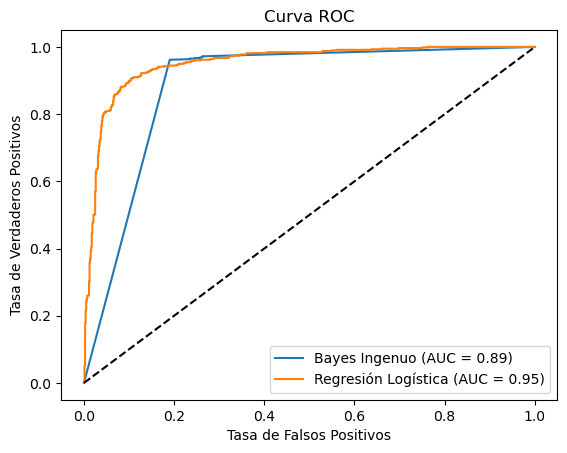

AUC Bayes Ingenuo: 0.8883
AUC Regresión Logística: 0.9517


In [128]:
# Graficar las curvas ROC
plt.figure()
plt.plot(fpr_nb, tpr_nb, label=f"Bayes Ingenuo (AUC = {auc_nb:.2f})")
plt.plot(fpr_logistic, tpr_logistic, label=f"Regresión Logística (AUC = {auc_logistic:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia para un modelo aleatorio
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Imprimir los valores del AUC
print(f"AUC Bayes Ingenuo: {auc_nb:.4f}")
print(f"AUC Regresión Logística: {auc_logistic:.4f}")